<font size=8 color=red><b>Feature Selection - 特征选择</font><br>
<font size=6 color=green><b>A Comprehensive Guide 实用大全</font>

In [3]:
import os
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import isnan
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer  

from sklearn.model_selection import train_test_split
from statistics import mode 
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
# use tensorflow as backend

from IPython.display import display, Markdown, Image
current = os.getcwd() 
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.insert(0, f"{parent_folder}\Classes")
from menu_A_a_data_utility import DataUtility

# A. Introduction 简介

Feature election is the process of selecting the subset of features to be used for training a machine learning model. 特征选择是选择用于训练机器学习模型的特征子集的过程
 

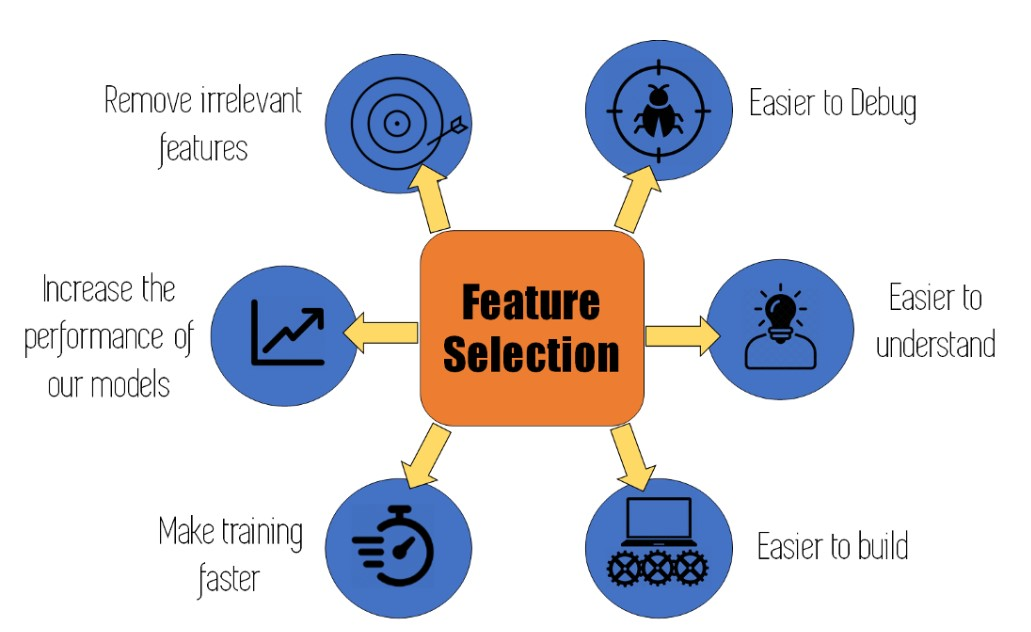

In [508]:
display(Image(parent_folder+"/Classes/gifs/fc_illustration.jpg"))

* Briefly, why we need fs?
    1. Irrelevant and redundant features
    2. Curse of dimensionality
    3. Training time
    4. Deployment effort
    5. Interpretability
    6. Occam’s Razor: parsimony 简约
    7. Data-model compatibility
  
 * Feature selection is preferable to feature transformation when the original features and their units are important and the modeling goal is to identify an influential subset. When categorical features are present, and numerical transformations are inappropriate, feature selection becomes the primary means of dimension reduction.
 
 * 简而言之，为什么我们需要 fs？
     1. 不相关和冗余的特征
     2. 维度的诅咒
     3. 训练时间
     4. 部署工作
     5. 可解释性
     6. Occam’s Razor：简约粗线
     7. 数据模型兼容性
  
  * 当原始特征及其单位很重要并且建模目标是识别有影响的子集时，特征选择优于特征转换。 当存在分类特征并且数值转换不合适时，特征选择成为降维的主要手段。

# B. Problem Statement

* Problem Statement: select a subset of 25 features, which consist of 21 sensors readings, 3 operation readings and current cycle, to predict remaining usage cycles an engine may have. 

* Output, i.e., the dependent variable, is RUL, continuous numeric data type. 
* Inputs, i.e., independent variables, are also continuous numeric data types

<br>B. 问题陈述

* 问题陈述：选择 25 个特征的子集，其中包括 21 个传感器读数、3 个操作读数和当前周期，以预测发动机可能具有的剩余使用周期。

* 输出，即因变量，是 RUL，连续数值数据类型。
* 输入，即自变量，也是连续数值数据类型

*. Load Data 加载数据

In [637]:
du = DataUtility()
DF_TRAIN, DF_TEST, DF_RESULT = du.prepare_dfs()  

In [635]:
DF_TRAIN["rul"] = DF_TRAIN.groupby(["id", "Flag"])["cycle"].transform("max") - DF_TRAIN["cycle"]
qry_str = "Flag=='FD001'"
DF_TRAIN1 = DF_TRAIN[DF_TRAIN.eval(qry_str)] 

y_train =  DF_TRAIN1.pop("rul")
X_train = DF_TRAIN1 

In [639]:
DF_TRAIN["Flag"].nunique()

4

# C. Math/python behind   基本数学/编程概念

## C1.1: Anova / f-test
* Anova uses f-test
* excercise from scratch: at cycle N, is there any difference among different setting (FD001 - 04)
* one-way
* Two types of ANOVA that are commonly used, the one-way ANOVA and the two-way ANOVA 
* independent varialbe: factor(s) 
* dependent: continues numerical measure 
* H0: no difference between groups and means 
* H1: there is difference 
* 1.2: Normality | Sample independence | Variance equality | continuous dependent variable

C1.1：方差分析 / f 检验
* Anova 使用 f 检验
* 从零开始练习：在N循环，不同设置（FD001 - 04）有什么区别
* 单程
* 常用的两种方差分析，单向方差分析和双向方差分析
* 自变量：因子
* 依赖：继续数值测量
* H0：组间和均值无差异
* H1：有区别
* 1.2：常态 | 样本独立性 | 方差相等 | 连续因变量

**prepare data**

In [519]:
def get_tmp(measure="sensor21", cycle = 8 ):
    tmp = DF_TRAIN.copy()
    measure = measure
    cycle = cycle
    factor = "Flag"
    qry_str = f"cycle=={cycle}"

    tmp = tmp[tmp.eval(qry_str)][[factor, measure]]  
    
    return tmp

**f-test**

An F-test is used to test whether two population variances are equal. <br>
The null and alternative hypotheses for the test are as follows:<br>
$ H0: \sigma_1^2 = \sigma_2^2 $ (the population variances are equal) <br>
$ H1: \sigma_1^2 \ne \sigma_2^2 $(the population variances are not equal)

$ \frac{\sigma_1^2 }{ \sigma_2^2} $ follows F-distributions

* assumption for f-test: An F-test assumes that data are normally distributed and that samples are independent from one anothe

* let test: for fault/op setting FD001 and FD002, are the variances of the same senor's reading when rul == N the same or not

In [540]:
#def get_f_data(cycle, sensor):
tmp = DF_TRAIN.copy()
N = 5 
sensor = "sensor21"

qry_str = f"(Flag=='FD001' | Flag=='FD002') & (rul=={N})"
tmp = tmp[tmp.eval(qry_str)][["Flag", sensor]] 


In [608]:
import numpy as np

#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
     
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p
 
set_x = tmp[tmp["Flag"]=="FD002"][sensor]
set_y =  tmp[tmp["Flag"]=="FD001"][sensor]

#perform F-test
f_statistic, p_value = f_test(set_x, set_y) 

print(f" f_statistic is: {'{:,.2f}'.format(f_statistic)} and p value is: {'{:,.4f}'.format(p_value)} ")

 f_statistic is: 10,237.14 and p value is: 0.0000 


`plot f-distribution`

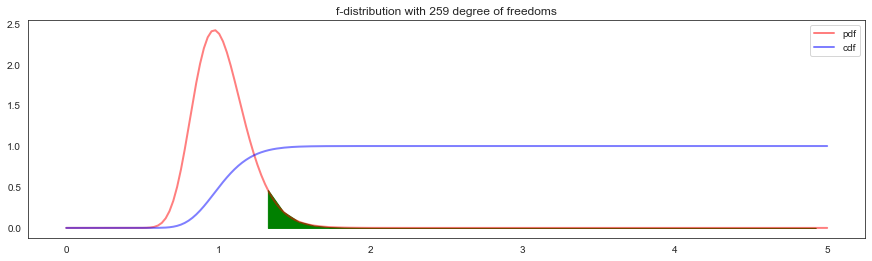

In [613]:
import scipy.stats as ss

plt.figure(figsize=(15,4))
def plot_f(x_range, dfn, dfd, mu=0, sigma=1, cdf=False, **kwargs):
    '''
    Plots the f distribution function for a given x range, dfn and dfd
    If mu and sigma are not provided, standard f is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.f.cdf(x, dfn, dfd, mu, sigma)  
    else:
        y = ss.f.pdf(x, dfn, dfd, mu, sigma) 
        
    plt.plot(x, y, **kwargs)
    return y 
      
def f_test(N=5, sensor="sensor21"):    
    
    tmp = DF_TRAIN.copy() 

    qry_str = f"(Flag=='FD001' | Flag=='FD002') & (rul=={N})"
    tmp = tmp[tmp.eval(qry_str)][["Flag", sensor]] 
    
    dn_fd001 = len(tmp[tmp["Flag"]=="FD001"][sensor])
    dn_fd002 = len(tmp[tmp["Flag"]=="FD002"][sensor])
    
    x = np.linspace(0.0, 5, 200)
    increment = 5/200
    alpha = 0.05

    dn_fd001= len(set_x) - 1
    dn_fd002= len(set_y) - 1

    plot_f(x, dn_fd001, dn_fd002, 0, 1, color='red', lw=2, ls='-', alpha=0.5, label='pdf')
    y = plot_f(x, dn_fd001, dn_fd002, 0, 1, cdf=True, color='blue', lw=2, ls='-', alpha=0.5, label='cdf')

    start = 0
    for i, value in enumerate(y):
        start = increment*i
        if value > 1-alpha:
            break

    px=np.arange(start,5,0.1)
    plt.fill_between(px, ss.f.pdf(px, dn_fd001, dn_fd002, 0, 1),color='g')
    
    plt.title(f"f-distribution with {dn_fd001} degree of freedoms")

    plt.legend();

f_test()

**anova**

`use tools`

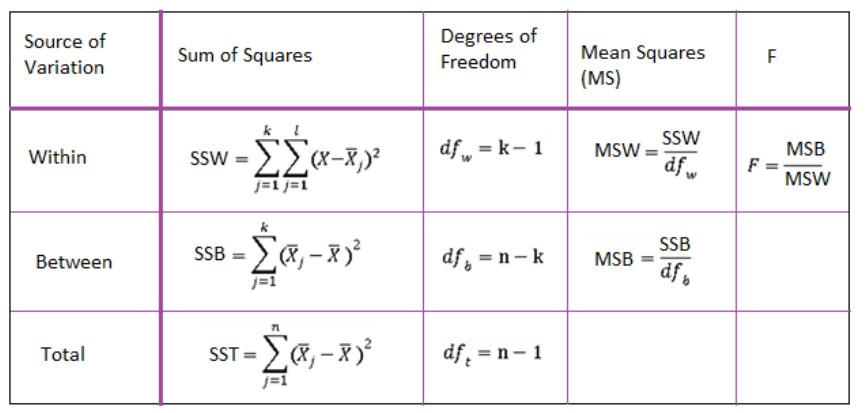

In [620]:
display(Image(parent_folder+"/Classes/gifs/anova.jpg"))

In [622]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats
import seaborn as sns
tmp = get_tmp()

lm = ols(f'{measure} ~ {factor}',data=tmp).fit()
table = sm.stats.anova_lm(lm)
print(table)

             df        sum_sq      mean_sq           F        PR(>F)
Flag        3.0  15701.528979  5233.842993  207.511039  1.887651e-96
Residual  705.0  17781.508508    25.221998         NaN           NaN


`from scratch and scipy`

H0 Rejected with p_value as 0.0</font>




H0: no difference between groups and means
H1: there is difference



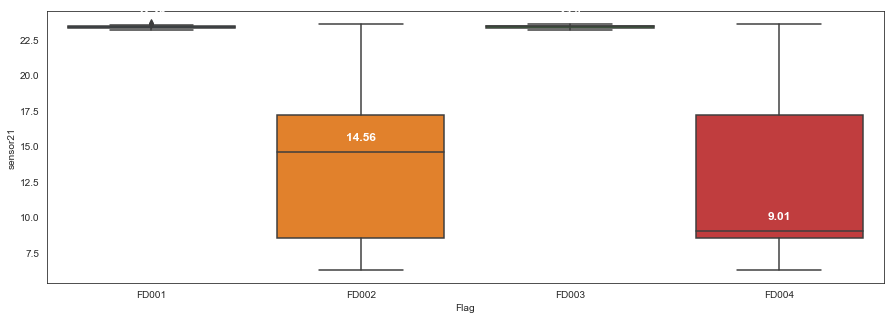

In [619]:
def one_way_anova(measure="sensor21", cycle = 8): 
    tmp = get_tmp(measure = measure, cycle = cycle)
    alpha = 0.05
    
    ## first boxplot it 
    fig = plt.figure(figsize=(15,5))
    sns.set_style("white") 
    box_plot = sns.boxplot(x=factor,y=measure,data=tmp)

    medians = tmp.groupby([factor])[measure].median()
    vertical_offset = tmp[measure].median() * 0.05 # offset from median for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,medians[xtick].round(2) + vertical_offset,medians[xtick].round(2), 
                horizontalalignment='center',size='large',color='w',weight='semibold')
 
    overall_mean = tmp[measure].mean()  
    # compute Sum of Squares Total
    tmp['overall_mean'] = overall_mean
    ss_total = sum((tmp[measure] - tmp['overall_mean'])**2) 

    # compute group means
    group_means = tmp.groupby(factor).mean()
    group_means = group_means.rename(columns = {measure: 'group_mean'}) 

    tmp = tmp.merge(group_means[["group_mean"]], left_on = factor, right_index = True) 
    ss_residual = sum((tmp[measure] - tmp['group_mean'])**2) 
    ss_explained = sum((tmp['overall_mean'] - tmp['group_mean'])**2)


    # compute Mean Square Residual
    n_groups = len(set(tmp[factor]))
    n_obs = tmp.shape[0]
    df_residual = n_obs - n_groups
    ms_residual = ss_residual / df_residual 

    # compute Mean Square Explained
    df_explained = n_groups - 1
    ms_explained = ss_explained / df_explained 

    # compute F-Value
    f = ms_explained / ms_residual

    # compute p-value
    p_value = 1 - scipy.stats.f.cdf(f, df_explained, df_residual)
    if p_value <= alpha:
        display(Markdown(f"H0 Rejected with p_value as {p_value.round(5)}</font>\n\n"))
    else:
        display(Markdown(f"H0 Stands with p_value as {p_value.round(5)}</font>\n\n"))
        
one_way_anova()
print('''
H0: no difference between groups and means
H1: there is difference
''')

## C1.2: t-test
* In statistics, t-tests are a type of hypothesis test that allows you to compare means.  
* There are three t-tests to compare means: a one-sample t-test, a two-sample t-test and a paired t-test.

**one sample:**
<font size=4> $t =  \frac{\bar{x} - \mu}{ s/\sqrt{n} } $</font><br>
$\bar{x}$ is sample mean <br>
$\mu$ population mean <br>
s sample standard deviation <br>
n is sample size


**two-sample:**
<font size=4> $t =  \frac{\bar{x1} - \bar{x2}}{\sqrt{s^2 (\frac{1}{n1} + \frac{1}{n2}}} $</font><br>
<font size=4>$s^2 = \frac{(n_1-1)s^2_{s_{x1}} + (n_2-1)s^2_{s_{x2}}}{n_1+n_2-2}$</font><br>
$\bar{x}$ is sample mean <br>
$\mu$ population mean <br>
s sample standard deviation <br>
n is sample size 

**paired**

<font size=4>$t=\frac{\bar{d}}{s_d\sqrt{n}}$</font><br>
here $\bar{d}$ is the mean of difference  
$s_d$ is standard deviation of sample differences 

* use tools

In [623]:
############## one sample ######################
# e.g., to answer this quesion. one engine sensor21's reading is at 23 at cycle 5, is it possible from the same distribute
from scipy import stats as st  
measure = "sensor21"
cycle = 23
flag = "FD001"
tmp = get_tmp(measure = measure, cycle = cycle ) 
tmp = tmp[tmp["Flag"]==flag]
          
vals =  tmp[measure].to_numpy() 
st.ttest_1samp(a=vals, popmean=23.36, alternative = "less") #"alternative" for two-sided, less, greater

Ttest_1sampResult(statistic=0.7565176701198766, pvalue=0.7744322829786023)

In [624]:
############## two sample ###################### 
from scipy import stats as st  
measure = "sensor21"
cycle = 23
flag = "FD001"
tmp = get_tmp(measure = measure, cycle = cycle ) 
m1 = tmp[tmp["Flag"] == "FD001"][measure]
m2 = tmp[tmp["Flag"] == "FD003"][measure]
           
st.ttest_ind(a=m1, b=m2, equal_var=True) #"alternative" for two-sided, less, greater 
# if equal_var == Fase, Welch's t-test. unequal variances and even un-equal sample size. 
# if True. standard t-test

Ttest_indResult(statistic=-0.4984558369714165, pvalue=0.6187160416658646)

In [625]:
############## paired ###################### 
from scipy import stats as st  
measure = "sensor21"
cycle = 23
flag = "FD001"
tmp = get_tmp(measure = measure, cycle = cycle ) 
m1 = tmp[tmp["Flag"] == "FD001"][measure]
m2 = tmp[tmp["Flag"] == "FD003"][measure]
           
st.ttest_rel(a=m1, b=m2 ) #"alternative" for two-sided, less, greater 
# if equal_var == Fase, Welch's t-test. unequal variances and even un-equal sample size. 
# if True. standard t-test

Ttest_relResult(statistic=-0.5073452797420849, pvalue=0.6130409102572836)

## C1.3. $\chi^2$  test 
* test of independence. The $\chi^2$ test is one of the statistical tests we can use to decide whether there is a correlation between the categorical variables by analysing the relationship between the observed and expected values <br>
$\chi^2 = \sum\frac{{(O_{i}-E_{i})}^2}{E_i} $ <br>

* Yates correction. The effect of Yates' correction is to prevent overestimation of statistical significance for small data. (usually 5)<br>
$\chi^2_{Yates}= \sum\frac{{(|O_{i}-E_{i}|-0.5)}^2}{E_i} $

* H0 : The two categorical variables have no relationship (independent), i.e., $P(A) = P(A|B)$
* H1 : There is a relationship (dependent) between two categorical variables

* let's make data. use cut

In [361]:
# goal: find is there any relationship between Op/Fault setting and Life 
tmp = DF_TRAIN.copy() 
tmp = tmp.groupby(["Flag", "id"])["cycle"].max().reset_index()
tmp["Life"] =  pd.cut(tmp['cycle'], bins=[0,200,300, 400, 500, 600], include_lowest=True,right=False, labels=["Low", "Mid-Low", "Mid", "Mid-High", "High"])
tmp.groupby("Life")["id"].count().reset_index()

,Life,id
0,Low,302
1,Mid-Low,318
2,Mid,74
3,Mid-High,13
4,High,2


In [363]:
contingency_table = pd.crosstab(tmp["Life"], tmp["Flag"]) 
print(contingency_table)

Flag      FD001  FD002  FD003  FD004
Life                                
Low          52    131     37     82
Mid-Low      44    117     42    115
Mid           4     12     12     46
Mid-High      0      0      8      5
High          0      0      1      1


In [364]:
import scipy.stats as stats 
stats.chi2_contingency(contingency_table)

(70.67658347030503,
 2.3926753314455915e-10,
 12,
 array([[ 42.59520451, 110.74753173,  42.59520451, 106.06205924],
        [ 44.85190409, 116.61495063,  44.85190409, 111.68124118],
        [ 10.43723554,  27.13681241,  10.43723554,  25.9887165 ],
        [  1.83356841,   4.76727786,   1.83356841,   4.56558533],
        [  0.28208745,   0.73342736,   0.28208745,   0.70239774]]))

* how to read above?
    1. chi2 statistic = 70.67658347030503
    2. p-value = 2.3926753314455915e-10
    3. df = (4-1)*(5-1) = 12
* conclusion: since p < 0.05, so, H0 is rejected. H1 stands. op/fault setting is related to life span

## C1.3. Correlations
* four types of correlations:  Pearson correlation, Kendall rank correlation, Spearman correlation, and the Point-Biserial correlation 

### C.1.3.1: Pearson correlation
* It is the ratio between the covariance of two variables and the product of their standard deviations <br>
$ r= \frac{\sum  (x-\bar{x})(y-\bar{y}) }{ \sqrt{\sum(x-\bar{x})^2 \sum(y-\bar{y})^2}} $ 

In [417]:
# prepare data. e.g., find rul versus sensors
 

,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,rul
6611,-0.0013,-0.0003,100.0,518.67,643.93,1605.51,1433.49,14.62,21.61,551.28,...,2388.31,8127.70,8.5146,0.03,397,2388,100.0,38.42,22.9862,0
15616,0.0016,-0.0002,100.0,518.67,642.29,1586.88,1399.23,14.62,21.61,554.24,...,2387.96,8135.45,8.4748,0.03,392,2388,100.0,39.11,23.5011,137


In [462]:
def cor_selector(col = "rul", flag = "FD001", num_feats = 10):
    
    qry_str = f"Flag=='{flag}'"  
    
    tmp = DF_TRAIN.copy()
    tmp = tmp[tmp.eval(qry_str)] 
     
    tmp.drop(columns=["id", "cycle", "Flag"], axis=1, inplace=True)

    y = tmp.pop("rul")
    X = tmp 
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    col_indexs = np.argsort(np.abs(cor_list))[-num_feats:]
    
    return cor_support, cor_feature, cor_list, col_indexs
 
cor_support, cor_feature, cor_list, col_indexs = cor_selector()
 

* dataframe build it

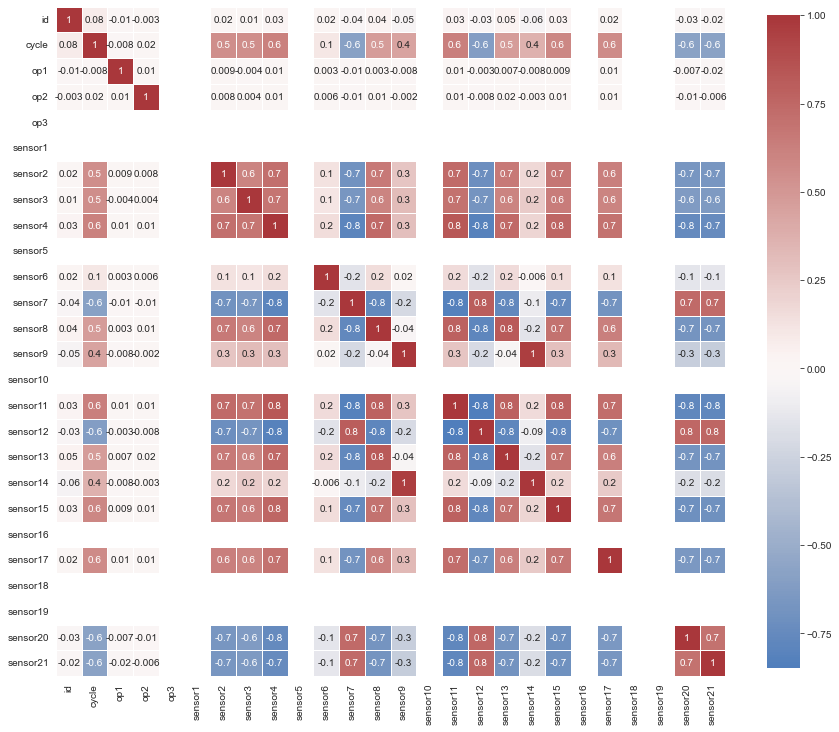

In [485]:
tmp = X_train.copy()
tmp = tmp[tmp["Flag"]=="FD001"]
tmp = tmp.select_dtypes(include="number")
df_corr = tmp.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(df_corr,  square=True, annot=True,  fmt=".1g",
            center=0,    linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

* detect multicollnearity
`Variance Inflation Factors - VIF`
<font size=4><br>
$ VIF_{i} = \frac{1}{1-R_{i}^2} $    
</font>
<br> min: 1. maximum: np.inf
<br> less than 5 is acceptable. less than 10 is ok

In [486]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

tmp = X_train.copy()
tmp = tmp[tmp["Flag"]=="FD001"]
tmp = tmp.select_dtypes(include="number")
tmp.drop(columns = ["id", "cycle"], inplace = True)

vif_data = pd.DataFrame()
vif_data["feature"] = tmp.columns
vif_data["VIF"] = [variance_inflation_factor(tmp.values, i) for i in range(len(tmp.columns))]
vif_data.round(2)


,feature,VIF
0,op1,1.00
1,op2,1.00
2,op3,0.00
3,sensor1,0.00
4,sensor2,2.60
5,sensor3,2.28
6,sensor4,4.59
7,sensor5,0.00
8,sensor6,1.03
9,sensor7,4.30


### C1.3.2: Kendall rank correlation 
* Kendall rank correlation is a non-parametric test that measures the strength of dependence between two variables.  If we consider two samples, a and b, where each sample size is n, we know that the total number of pairings with a b is n(n-1)/2.  The following formula is used to calculate the value of Kendall rank correlation:

<font size=4>$\tau = \frac{n_c - n_d  }{\frac{1}{2}n(n-1)} $</font>

$n_c$: number of concordant <br>
$n_d$: number of discordant

### C1.3.3: Spearman rank correlation
* Spearman rank correlation is a non-parametric test that is used to measure the degree of association between two variables. <br>
* The following formula is used to calculate the Spearman rank correlation: <br>

<font size=4>$ \rho = 1 -  \frac{6\sum d_i^2}{n(n^2 -1)} $</font>

$\rho$: spearman rank correlation <br>
$d_i$ the difference between the ranks of correspondent variables <br>
n: number of observations


* Kendall and Spearman are mostly interchangeable. Kendall is more robust


### C1.3.4: Point-Biserial correlation
* The Point-Biserial Correlation Coefficient is a correlation measure of the strength of association between a continuous-level variable (ratio or interval data) and a binary variable. Binary variables are variables of nominal scale with only two values.
* classical usage: test whether a multiple choise test is too easy or too hard. 

<font size=4>$r_{pb} = \frac{M_0 - M_1}{S_y} \sqrt{\frac{n_0}{n} \frac{n_1}{n}}$ </font>

$M_0$: the mean of data from group 0 <br>
$M_1$: mean of group 1 <br>
$S_y$: the stdev of continuous data <br>
$n_0$: group 0 <br>
$n_1$: group 1 <br>
$n$: total <br>

* A correlation closer to 0 or negative would suggest that the question was perhaps poorly made or not fair to give to the students

In [495]:
import pandas as pd
from scipy.stats import pointbiserialr

tmp = DF_TRAIN.copy()
col = "sensor21"
fds = ["FD001", "FD002"]

tmp = tmp[tmp["Flag"].isin(fds)][["Flag", col]]

# get continuous and dichotomous data


tmp_dic = {"FD001":0, "FD002": 1}
tmp["Flag"] = tmp["Flag"].map(tmp_dic)

sets = tmp['Flag']
reading = tmp[col]

# pbc of first question
pbc = pointbiserialr(question_1, grades)
print(pbc)


PointbiserialrResult(correlation=-0.6932332897269851, pvalue=0.0)


## C1.4: Information Theory Basics
### C1.4.1.  Concepts:
    1. MI. Mutual Information
    2. IG. Information Gain, Entropy reduction. 
    3. Entropy. In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent to the variable's possible outcomes.
    4. KL. Kullback-Leibler divergence.  a measure that calculates the difference between two probability distributions.
 

### C1.4.2. Calculate Entropy

$ E = - \sum\limits_{i=0}^N P_ilog_2P_i $
<br>$P_i $ is probability of randomly select one being class i. total N classes 

* entropy = 0: pure
* entropy the higher the messier

**calculate Entropy fault/op setting**

In [669]:
from collections import Counter 
tmp = DF_TRAIN.copy()
tmp = tmp[["id", "Flag"]].drop_duplicates().values
counts = Counter(tmp[:,1])
total = tmp.shape[0]

# calculate Entropy:
E = 0 
for k,v in counts.items():
    display(Markdown(f" * $ - P_{{{k}}}log_2P_{{{k}}} =   {'{:,.2f}'.format( -(v/total)*np.log2(v/total))}$"))
    E +=  -(v/total)*np.log2(v/total)
E

 * $ - P_{FD001}log_2P_{FD001} =   0.40$

 * $ - P_{FD002}log_2P_{FD002} =   0.53$

 * $ - P_{FD003}log_2P_{FD003} =   0.40$

 * $ - P_{FD004}log_2P_{FD004} =   0.53$

1.8580376558469984

### C1.4.3. MI and KL
* Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.
* Kullback-Leibler, or KL, divergence is a measure that calculates the difference between two probability distributions.
<br> $ I(X;Y) = H(X) - H(X|Y)  $ <br>
Where I(X ; Y) is the mutual information for X and Y, H(X) is the entropy for X and H(X | Y) is the conditional entropy for X given Y. The result has the units of bits.<br><br>
Sometime it is also expressed in KL: <br>
$ I(X;Y) = KL(p(X,Y) || p(X)*p(Y)) $ <br>
they are not the same. 


* calculate KL 

$ KL(P||Q) = \sum p_i(x)log( \frac{p_i(x)}{q_i(x)}) $ <br>
if continuous: <br>
$  KL(P||Q) = \int p(x) log\frac{p(x)}{q(x)} $ 

### C1.4.4. KL in scipy

* scipy implementation of KL

In [ ]:
from scipy.special import rel_entr

#calculate (P || Q)
sum(rel_entr(P, Q))


### C1.4.5. sklearn implementation of MI

In [682]:
from sklearn.feature_selection import mutual_info_classif as MIC
tmp = DF_TRAIN.copy() 
y = tmp.pop("Flag")
tmp["Life"] =  pd.cut(tmp['cycle'], bins=[0,200,300, 400, 500, 600], include_lowest=True,right=False, labels=["Low", "Mid-Low", "Mid", "Mid-High", "High"])
tmp_fd = pd.get_dummies(tmp[["Life"]], columns=["Life"], prefix=["Life_"] ) 
mic_score = MIC(tmp_fd.values,y,n_neighbors=3, discrete_features = True) # it is an estimate
 
print(mic_score, sum(mic_score))
# It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
 

[0.01392227 0.00611364 0.00799475 0.00452494 0.00027936] 0.032834958510925945


### C1.4.6. Some guidelines for stats method consideration 
特征选择方法一览

In [375]:
from pathlib import Path

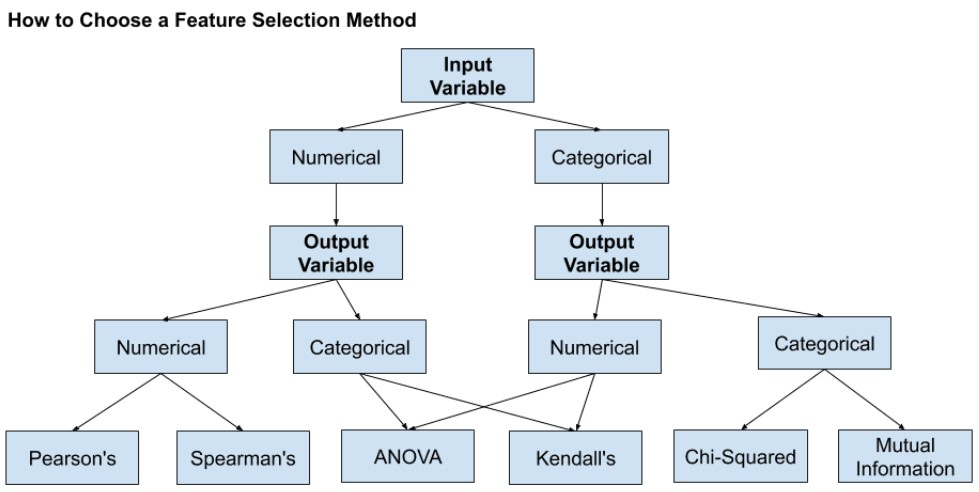

In [391]:
img_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/classes/gifs/fs_cheatsheet.jpg"
display(Image(img_path))

<html>
<font size="15" face="Courier New" >
<table width="100%">
<tr><td>Input Variable</td><td>Output Variable</td><td>Feature Selection Stats</td></tr> 
<tr><td>Numerical</td><td>Numerical</td><td>Pearson’s correlation coefficient<br>
Spearman’s rank coefficient </td></tr> 
<tr><td>Numerical</td><td>Categorical</td><td>ANOVA correlation coefficient (linear).<br>
Kendall’s rank coefficient (nonlinear).</td></tr> 
<tr><td>Categorical</td><td>Numerical</td><td>Kendall’s rank coefficient (linear).<br>
ANOVA correlation coefficient (nonlinear).</td></tr> 
<tr><td>Categorical</td><td>Categorical</td><td>Feature Selection Stats</td></tr>   
</table>
</font>
</html>

### C1.4.7. some implementations in skelar 
* pearson-r: sklearn.feature_selection.r_regression(X, y, *, center=True, force_finite=True)
* f-stats: sklearn.feature_selection.f_regression(X, y, *, center=True, force_finite=True) Univariate linear regression tests returning f-statistic and p-values
* mutual information: sklearn.feature_selection.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
* anova: sklearn.feature_selection.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
* $\chi^2 test: $ sklearn.feature_selection.chi2(X, y)

### C1.4.8. high level Technicals 技巧概要

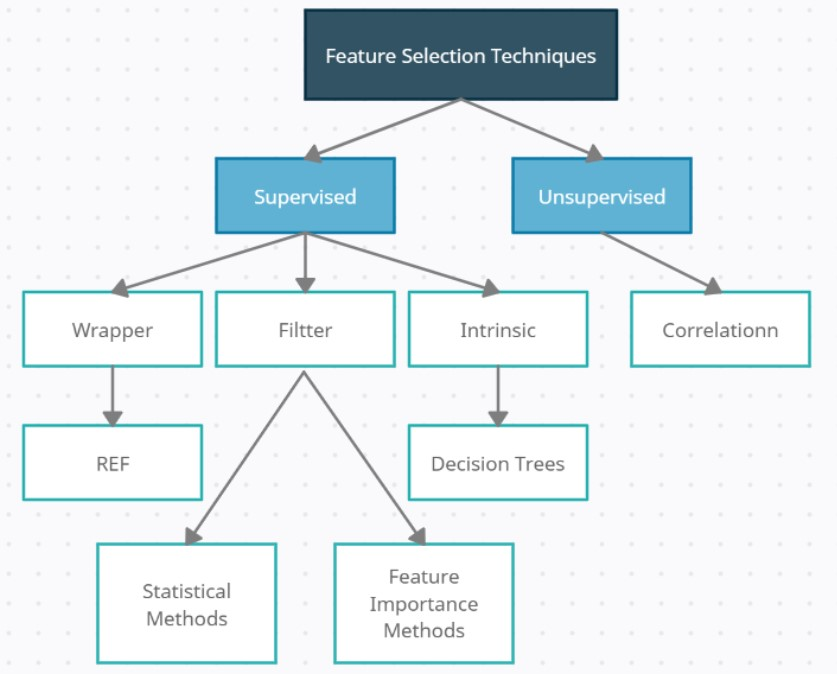

In [487]:
img_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/classes/gifs/fs_techniques.jpg"
display(Image(img_path))

# D. FS - Round One Inspecting and Filtering 第一轮检查和过滤 
    1. Variance: has been shown to be an effective way to select relevant features which tend to have a higher variance score
    Implementation: Variance Threshold

    2. Mean absolute difference: computes the mean absolute difference from the mean value (implementation).

    Higher values tend to have more discriminative power

    3. Dispersion ratio: the arithmetic mean divided by the geometric mean. Higher dispersion corresponds to more relevant features (implementation)
 
    4. Laplacian Score: is based on the observation that data from the same class is often close to each other and thus we can evaluate the importance of a feature by its power of locality preserving. The method consists in embedding the data on a nearest neighbor graph by using an arbitrary distance measure and then calculating a weight matrix. A laplacian score is then calculated for each feature and will have the property that smallest values correspond to the most important dimensions. However, in order to select a subset of features another clustering algorithm (e.g. k-means) is typically applied a-posteriori in order to select the best performing group
    Implementations : scikit-feature

    5. Laplacian Score combined with distance-based entropy: this algorithm builds on top of the Laplacian score and uses distance-based entropy to replace the typical k-means clustering and shows better stability in high-dimensional datasets (implementation)

    6. MCFS (Multi-Cluster Feature selection): a spectral analysis is performed to measure the correlation between different features. The top eigenvectors of the graph Laplacian are used to cluster the data and a feature score is being computed as explained in the original paper.
    Implementation : https://github.com/danilkolikov/fsfc

    7. LFSBSS (Localised feature selection), weighted k-means, SPEC and Apriori algorithms have been described in this review paper and are implemented in this package
    
1. 方差：已被证明是选择方差分数较高的相关特征的有效方法
    实施：方差阈值

    2. 平均绝对差：从平均值计算平均绝对差（实现）。

    较高的值往往具有更大的辨别力

    3. 分散比：算术平均数除以几何平均数。较高的分散对应于更多相关的特征（实现）
 
    4.拉普拉斯分数：基于观察到来自同一类的数据通常彼此接近，因此我们可以通过其局部保持能力来评估特征的重要性。该方法包括通过使用任意距离度量将数据嵌入到最近邻图上，然后计算权重矩阵。然后为每个特征计算一个拉普拉斯分数，并将具有最小值对应于最重要维度的属性。然而，为了选择特征的子集，通常会应用另一种聚类算法（例如 k-means）后验以选择性能最佳的组
    实现：scikit-feature

    5、拉普拉斯分数结合基于距离的熵：该算法建立在拉普拉斯分数之上，使用基于距离的熵来代替典型的k-means聚类，在高维数据集中表现出更好的稳定性（实现）

    6. MCFS（Multi-Cluster Feature selection）：进行光谱分析以测量不同特征之间的相关性。图拉普拉斯算子的顶部特征向量用于对数据进行聚类，并按照原始论文中的说明计算特征分数。
    实施：https://github.com/danilkolikov/fsfc

    7. LFSBSS（本地化特征选择）、加权 k 均值、SPEC 和 Apriori 算法已在本评论论文中进行了描述，并在此包中实现    

## D1.1.  Drop Nulls 删除空值
* simplest: tmp.dropna(how='all') or tmp.dropna(how='any')
* by thresh: number of not nan values by 0 or 1, e.g., tmp.dropna(thresh=15, axis = 0 ) 
* by subset: tmp.dropna(subset=['Flag', 'id'], how = "any")
* remember: inplace or not

最简单：tmp.dropna(how='all') 或 tmp.dropna(how='any') <br>
by thresh：非 nan 值的数量为 0 或 1，例如 tmp.dropna(thresh=15, axis = 0 ) <br>
按子集：tmp.dropna(subset=['Flag', 'id'], how = "any") <br>
记住：就地与否 <br>

In [141]:
tmp = X_train.copy() 
p = np.random.uniform(low = 0.0, high = 0.4, size = None)
tf = np.random.choice([True, False], size = tmp.shape, p =[p, 1-p])
tmp = tmp.mask(tf)

In [142]:
tmp.dropna(how="any")

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,Flag
8824,44.0,141.0,0.0027,0.0004,100.0,518.67,642.70,1596.45,1408.63,14.62,...,2388.06,8155.77,8.3977,0.03,392.0,2388.0,100.0,38.82,23.3782,FD002
35971,172.0,84.0,42.0067,0.8400,100.0,445.00,549.54,1350.39,1121.21,3.91,...,2387.89,8084.50,9.3968,0.02,330.0,2212.0,100.0,10.60,6.3692,FD002
18295,73.0,126.0,-0.0005,0.0002,100.0,518.67,641.70,1578.40,1386.08,14.62,...,2387.97,8142.69,8.3972,0.03,390.0,2388.0,100.0,38.90,23.3562,FD003
9834,40.0,182.0,10.0067,0.2504,100.0,489.05,605.27,1509.99,1320.13,10.52,...,2388.28,8135.31,8.7053,0.03,371.0,2319.0,100.0,28.20,17.0006,FD004


## D1.2. Variance
* primary goal: remove zero varience 

<font size=5>$ \sigma^2 = \frac{1}{n}\sum\limits_{i=0}^{n} (x_{i} - \bar{x})^2$</font>

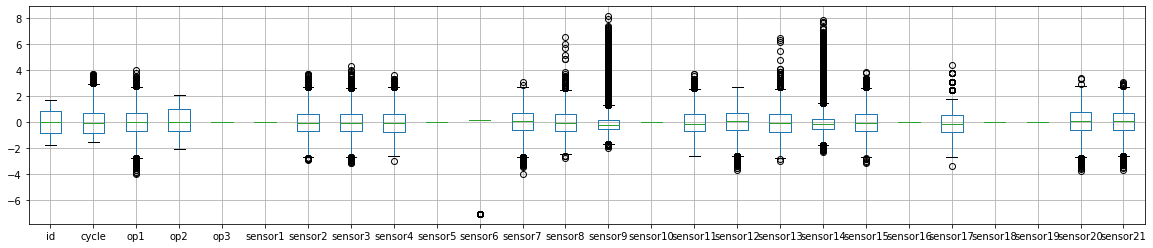

In [54]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

def var_analysis_prepare():
    tmp = X_train.copy()   
     
    tmp = tmp[tmp["Flag"]=="FD001"]
    tmp = tmp.select_dtypes(include="number") 
    
    ss = StandardScaler()
    tmp[list(tmp)] = ss.fit_transform(tmp)  
     
    tmp.boxplot(figsize=(20, 4) )
    plt.show()    
    return tmp 
tmp = var_analysis_prepare()

* variance

In [173]:
from sklearn.feature_selection import VarianceThreshold
np.set_printoptions(suppress=True)

def var_check():
    tmp = X_train.copy()
    tmp = tmp.select_dtypes(include = "number") 
    tmp.drop(columns = ["id", "cycle"], inplace = True) 
    
    for th in [0, 5, 50, 100, 200]:
        va = VarianceThreshold(th)
        va.fit(tmp)
        dff = pd.DataFrame(va.transform(tmp), columns = va.get_feature_names_out())
        print(f"colums left {len(va.get_feature_names_out())}. Original: {va.n_features_in_}")  
        #va.feature_names_in_[va.variances_>=0]
        #va.n_features_in_, va.get_feature_names_out() 
        
var_check() 

colums left 24. Original: 24
colums left 20. Original: 24
colums left 15. Original: 24
colums left 15. Original: 24
colums left 13. Original: 24


## D1.3. MAD - mean absolute difference 
* straight forward. mad 

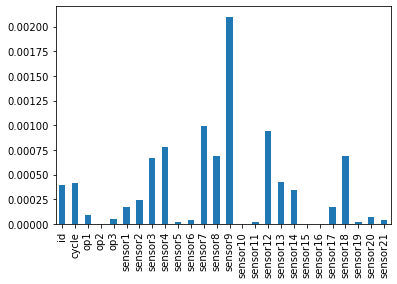

In [196]:
tmp = X_train.copy()
tmp = tmp.select_dtypes(include="number")
(tmp.mad()/tmp.shape[0]).plot(kind="bar")
plt.show()

## D1.4. Dispersion ratio 
* the arithmetic mean divided by the geometric mean. Higher dispersion corresponds to more relevant features
* what is geometry mean? <br><font size = 4>
$(\prod\limits_{i=1}^{n}x_{i})^{\frac{1}{n}} = \sqrt[n]{x_{1}x_{2}...x_{n}} $
<br> same as: <br>
$(\prod\limits_{i=1}^{n}x_{i})^{\frac{1}{n}} = exp [\ \frac{1}{n} \sum\limits_{i=1}^{n} ln x_{i}  ]\ $    
</font>

In [189]:
def dispersion(data):
    data = data +1 #avoid 0 division
    arith_mean = np.mean(data, axis =0 )
    #geo_mean = np.power(np.prod(data, axis =0 ),1/data.shape[0]) 
    vals = sum(np.log1p(data))/len(data)
    vals = np.exp(vals)
    geo_mean = vals 
    R = arith_mean/geo_mean
    
    return R

dr = dispersion(tmp["sensor12"])

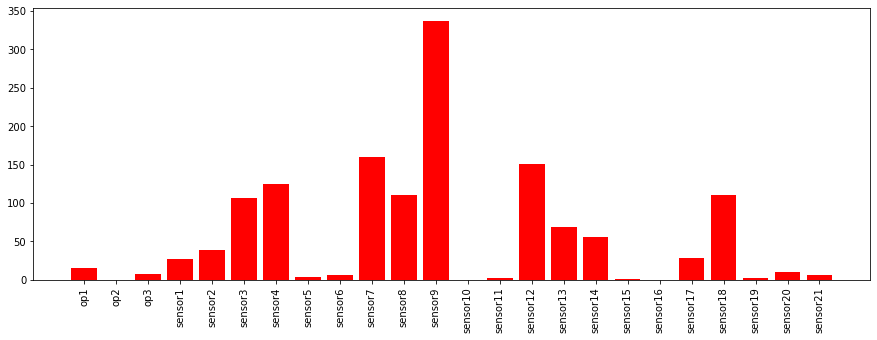

In [195]:
tmp = X_train.copy()
tmp = tmp.select_dtypes(include = "number")

tmp.drop(columns = ["id", "cycle"], inplace = True) 
plt.figure(figsize = (15, 5))

mad = np.sum(np.abs(tmp - np.mean(tmp, axis = 0)), axis = 0)/tmp.shape[0]
ax = plt.bar(list(tmp), mad, color = "red")
plt.xticks(rotation = 90)
plt.show()

## D1.5. Other less common 其他不太常见方法
* Laplacian Score: is based on the observation that data from the same class is often close to each other and thus we can evaluate the importance of a feature by its power of locality preserving. 
* Laplacian Score combined with distance-based entropy
* MCFS (Multi-Cluster Feature selection)
* LFSBSS (Localised feature selection)

* 拉普拉斯分数：基于观察到来自同一类的数据通常彼此接近，因此我们可以通过其局部保持能力来评估特征的重要性。
* 拉普拉斯分数与基于距离的熵相结合
* MCFS（多集群特征选择）
* LFSBSS（本地化特征选择）


# E: FS Methodologies 特征选择方法 

 
* Feature selection reduces the dimensionality of data by selecting only a subset of measured features (predictor variables) to create a model. Feature selection algorithms search for a subset of predictors that optimally models measured responses, subject to constraints such as required or excluded features and the size of the subset. The main benefits of feature selection are to improve prediction performance, provide faster and more cost-effective predictors, and provide a better understanding of the data generation process [1]. Using too many features can degrade prediction performance even when all features are relevant and contain information about the response variable.

* Feature selection algorithms are classified into three types:

    1. Filter Type Feature Selection — The filter type feature selection algorithm measures feature importance based on the characteristics of the features, such as feature variance and feature relevance to the response. You select important features as part of a data preprocessing step and then train a model using the selected features. Therefore, filter type feature selection is uncorrelated to the training algorithm.

    2. Wrapper Type Feature Selection — The wrapper type feature selection algorithm starts training using a subset of features and then adds or removes a feature using a selection criterion. The selection criterion directly measures the change in model performance that results from adding or removing a feature. The algorithm repeats training and improving a model until its stopping criteria are satisfied.

    3. Embedded Type Feature Selection — The embedded type feature selection algorithm learns feature importance as part of the model learning process. Once you train a model, you obtain the importance of the features in the trained model. This type of algorithm selects features that work well with a particular learning process.

* 特征选择通过仅选择测量特征的子集（预测变量）来创建模型，从而降低了数据的维度。特征选择算法搜索对测量响应进行最佳建模的预测变量子集，受所需或排除特征和子集大小等约束条件的约束。特征选择的主要好处是提高预测性能，提供更快和更具成本效益的预测器，并提供对数据生成过程的更好理解 [1]。即使所有特征都相关并且包含有关响应变量的信息，使用太多特征也会降低预测性能。

* 特征选择算法分为三类：

    1. 过滤器类型特征选择——过滤器类型特征选择算法根据特征的特征来衡量特征的重要性，例如特征方差和特征与响应的相关性。您选择重要特征作为数据预处理步骤的一部分，然后使用所选特征训练模型。因此，过滤器类型的特征选择与训练算法无关。

    2. 包装类型特征选择——包装类型特征选择算法使用特征子集开始训练，然后使用选择标准添加或删除特征。选择标准直接衡量因添加或删除特征而导致的模型性能变化。该算法重复训练和改进模型，直到满足其停止标准。

    3. 嵌入式特征选择——嵌入式特征选择算法学习特征重要性作为模型学习过程的一部分。一旦你训练了一个模型，你就会获得训练模型中特征的重要性。这种类型的算法选择与特定学习过程配合良好的特征。<br>

<br><br>
<font size=4><b>  Filter Methods </b></font></b></font>

- Filter methods consists of various techniques as given below:-

  1.    Basic methods
  2.    Univariate methods 
  3.    Correlation Matrix with Heatmap
  
- 过滤方法包括各种技术，如下所示：-

   一、基本方法
   2. 单变量方法
   3. 带有热图的相关矩阵
   
<font size=4><b><font size=4><b>  Wrapper Methods </b></font></b></font>

- Wrapper methods consists of the following techniques:-

  1.    Forward Selection
  2.    Backward Elimination
  3.    Exhaustive Feature Selection
  4.    Recursive Feature Elimination
  5.    Recursive Feature Elimination with Cross-Validation
  
- 包装器方法包括以下技术：-

   1. 前向选择
   2. 后向消除
   3. 详尽的特征选择
   4.递归特征消除
   5. 使用交叉验证的递归特征消除  
  
<font size=4><b><font size=4><b>  Embedded Methods  </b></font></b></font>
<br>嵌入式方法
    <font size=4><b><font size=4><b> Embedded methods consists of the following techniques:- </b></font>

  1.   LASSO
  2.   RIDGE
  3.   Tree Importance
  
 

## E1. Filter Methods
* Independent of machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. The characteristics of these methods are as follows:-

    * These methods rely on the characteristics of the data (feature characteristics)
    * They do not use machine learning algorithms.
    * These are model agnostic.
    * They tend to be less computationally expensive.
    * They usually give lower prediction performance than wrapper methods.
    * They are very well suited for a quick screen and removal of irrelevant features.
    * Filter methods consists of various techniques as given below:-

    1. Basic methods
    2. Univariate feature selection
    3. Information gain
    4. Fischer score
    5. ANOVA F-Value for Feature Selection
    6. Correlation Matrix with Heatmap 
    
E1。 过滤方法
* 独立于机器学习算法。 相反，特征是根据它们在各种统计测试中与结果变量的相关性的分数来选择的。 这些方法的特点如下：-

     * 这些方法依赖于数据的特征（特征特征）
     * 他们不使用机器学习算法。
     * 这些与模型无关。
     * 它们的计算成本往往较低。
     * 它们通常提供比包装方法更低的预测性能。
     * 它们非常适合快速筛选和删除不相关的功能。
     *过滤器方法包括各种技术，如下所示：-

     一、基本方法
     2. 单变量特征选择
     3.信息增益
     4. Fischer 评分
     5. 特征选择的方差分析 F 值
     6. 带有热图的相关矩阵    

### E1.1: Basec Methods 基本方法
* Mostly covered in Round One per Part D 见 Part D


### E1.2.  Univariate selection methods
* usually the following the following conventional methods
    1. SelectKBest
    2. SelectPercentile
    3. SelectFpr, SelectFdr, or family wise error SelectFwe
    4. GenericUnivariateSelect 
    
E1.2。 单变量选择方法
* 通常有以下以下常规方法
     1.选择KBest
     2.选择百分位数
     3. SelectFpr, SelectFdr, or family wise error SelectFwe
     4. 通用单变量选择    

#### E1.2.1. SelectKBest

In [683]:
# prepare data.    

In [697]:
tmp = DF_TRAIN.copy()
tmp["rul"] = tmp.groupby(["id", "Flag"])["cycle"].transform("max") - tmp["cycle"]

fault_op = "FD001"
qry_str = f"Flag=='{fault_op}'"

tmp = tmp[tmp.eval(qry_str)]  
tmp["Distance_To_Fail"] =  pd.cut(tmp['rul'], bins=[0,20,50, 100, 200, 600], include_lowest=True,right=True, labels=["Low", "Mid-Low", "Mid", "Mid-High", "High"])
   

*  First run it
* dissect sklearn selectKBest

**class sklearn.feature_selection.SelectKBest(score_func=<function f_classif>, \*, k=10)**
`score_func` <br>
     |  f_classif: ANOVA F-value between label/feature for classification tasks. <br>
     |  mutual_info_classif: Mutual information for a discrete target.<br>
     |  chi2: Chi-squared stats of non-negative features for classification tasks.<br>
     |  f_regression: F-value between label/feature for regression tasks.<br>
     |  mutual_info_regression: Mutual information for a continuous target.<br>
     |  SelectPercentile: Select features based on percentile of the highest scores.<br>
     |  SelectFpr : Select features based on a false positive rate test.<br>
     |  SelectFdr : Select features based on an estimated false discovery rate.<br>
     |  SelectFwe : Select features based on family-wise error rate.<br>
     |  GenericUnivariateSelect : Univariate feature selector with configurable mode.<br>

`what do we need from the selector` <br>
    fit(X, y) Run score function on (X, y) and get the appropriate features.<br>
    fit_transform(X[, y])  Fit to data, then transform it.<br>
    get_feature_names_out([input_features])  Mask feature names according to selected features.<br>
    get_params([deep]) Get parameters for this estimator.<br>
    get_support([indices])   Get a mask, or integer index, of the features selected.<br>
    inverse_transform(X)  Reverse the transformation operation.<br>
    set_params(**params)  Set the parameters of this estimator.<br>
    transform(X)  Reduce X to the selected features.<br>
   

* classification

In [710]:
tmp_clf = tmp.copy()
y = tmp_clf.pop("Distance_To_Fail")
tmp_clf.drop(columns=["id", "cycle", "Flag", "rul"], inplace=True)

# important: none negative
tmp_clf[tmp_clf < 0] = 0


In [714]:
from sklearn.feature_selection import SelectKBest, chi2 
# select the two best features
kb = SelectKBest(chi2, k=10)
X_new = kb.fit_transform(tmp_clf, y)

kb.get_feature_names_out()

array(['sensor3', 'sensor4', 'sensor7', 'sensor9', 'sensor11', 'sensor12',
       'sensor14', 'sensor17', 'sensor20', 'sensor21'], dtype=object)

* regression

In [715]:
tmp_clf = tmp.copy()
y = tmp_clf.pop("rul")
tmp_clf.drop(columns=["id", "cycle", "Flag", "Distance_To_Fail"], inplace=True)

# important: none negative
tmp_clf[tmp_clf < 0] = 0

In [716]:
from sklearn.feature_selection import SelectKBest, f_regression 
# select the two best features
kb = SelectKBest(f_regression, k=10)
X_new = kb.fit_transform(tmp_clf, y)

kb.get_feature_names_out()

array(['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor11', 'sensor12',
       'sensor15', 'sensor17', 'sensor20', 'sensor21'], dtype=object)

#### E1.2.2. SelectPercentile
* directly use sklearn <br>
    from sklearn.feature_selection import SelectPercentile <br>
    similar to SelectKBest

In [720]:
from sklearn.feature_selection import SelectPercentile 

# sklearn.feature_selection.SelectPercentile(score_func=<function f_classif>, *, percentile=10) 

#### E1.2.3. SelectFpr, SelectFdr, or family wise error SelectFwe

* Fpr -- False Positive Rate. Select the pvalues below alpha based on a FPR test. alpha=0.05 byy default
* Fdr -- False dicovery rate.  Select the p-values for an estimated false discovery rate. FDR = expected (# false predictions/ # total predictions)

In [723]:
from sklearn.feature_selection import SelectFdr, f_regression
fdr = SelectFdr(score_func=f_regression, alpha=0.05)

tmp_clf = tmp.copy()
y = tmp_clf.pop("rul")
tmp_clf.drop(columns=["id", "cycle", "Flag", "Distance_To_Fail"], inplace=True)

# important: none negative
tmp_clf[tmp_clf < 0] = 0 
X_new = fdr.fit_transform(tmp_clf, y) 
fdr.get_feature_names_out()

array(['sensor2', 'sensor3', 'sensor4', 'sensor6', 'sensor7', 'sensor8',
       'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor17', 'sensor20', 'sensor21'], dtype=object)

#### E1.2.4: GenericUnivariateSelect
* class sklearn.feature_selection.GenericUnivariateSelect(score_func=<function f_classif>, *, mode='percentile', param=1e-05)
* Univariate feature selector with configurable strategy.
* flexible
* previous 3 category are subsets

### E1.3. Heatmap / Correlation. 热图/相关性
* Covered in EDA

## E2. Wrapper Methods 包装方法

### E2.1 Intro
* In wrapper methods, we try to use a subset of features and train a model using them. Based on the inferences that we draw from the previous model, we decide to add or remove features from the subset. The problem is essentially reduced to a search problem. These methods are usually computationally very expensive. 

Some common examples of wrapper methods are:<br>
    1. Forward selection <br>
    2. Backward elimination <br>
    3. Exhaustive feature selection <br>
    4. Recursive feature elimination <br>
    5. Recursive feature elimination with cross-validation  <br>
    
* we will learn a new lib called xlxtend
* please note that sklearn also has SequentialFeatureSelector 

在包装方法中，我们尝试使用特征子集并使用它们训练模型。 基于我们从之前的模型中得出的推论，我们决定从子集中添加或删除特征。 这个问题本质上被简化为一个搜索问题。 这些方法通常在计算上非常昂贵。

包装器方法的一些常见示例是：<br>
     1.正向选择<br>
     2. 向后消除 <br>
     3. 详尽的特征选择<br>
     4. 递归特征消除 <br>
     5. 使用交叉验证的递归特征消除 <br>
    
* 我们将学习一个名为 xlxtend 的新库
* 请注意 sklearn 也有 SequentialFeatureSelector

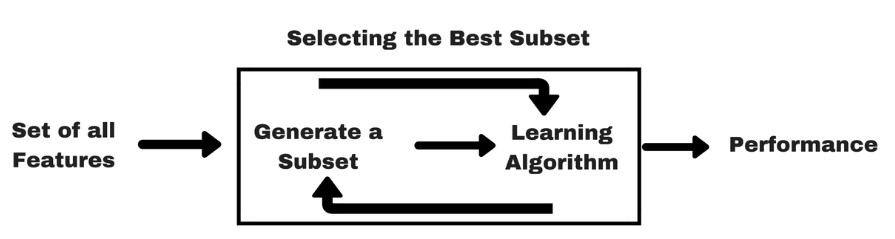

In [728]:
display(Image(parent_folder+"/Classes/gifs/wrapper.jpg"))

### E2.2 Forward selection  前向选择
* Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.
* 前向选择是一种迭代方法，我们从模型中没有特征开始。 在每次迭代中，我们不断添加最能改善模型的特征，直到添加新变量不会提高模型的性能。

In [ ]:
!pip install mlxtend

In [732]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
tmp_clf = tmp.copy()
y = tmp_clf.pop("rul")
tmp_clf.drop(columns=["id", "cycle", "Flag", "Distance_To_Fail"], inplace=True)

# important: none negative
tmp_clf[tmp_clf < 0] = 0 
 
sfs1 = SFS(RandomForestRegressor(), 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=3)

sfs1 = sfs1.fit(tmp_clf.values, y)

* results:

In [ ]:
sfs1.k_feature_idx_ 
tmp_clf.columns[list(sfs1.k_feature_idx_)]

### E2.3. Backward Elimination 后向消除
* In backward elimination, we start with all the features and removes the least significant feature at each iteration which improves the performance of the model. We repeat this until no improvement is observed on removal of features.

* 在反向消除中，我们从所有特征开始，并在每次迭代中移除最不重要的特征，从而提高模型的性能。 我们重复此操作，直到在移除特征时没有观察到改进。

In [ ]:
# step backward feature elimination

tmp_clf = tmp.copy()
y = tmp_clf.pop("rul")
tmp_clf.drop(columns=["id", "cycle", "Flag", "Distance_To_Fail"], inplace=True)

# important: none negative
tmp_clf[tmp_clf < 0] = 0 

sfs2 = SFS(RandomForestRegressor(), 
           k_features=10, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=3)

sfs2 = sfs2.fit(tmp_clf.values, y)

### E2.4.  Exhaustive Feature Selection 详尽的特征选择
* In an exhaustive feature selection the best subset of features is selected, over all possible feature subsets, by optimizing a specified performance metric for a certain machine learning algorithm

* 在详尽的特征选择中，通过优化特定机器学习算法的指定性能指标，在所有可能的特征子集中选择最佳的特征子集

### E2.5. Recursive Feature elimination: RFE 递归特征消除 
* It is a greedy optimization algorithm which aims to find the best performing feature subset. It repeatedly creates models and keeps aside the best or the worst performing feature at each iteration. It constructs the next model with the left features until all the features are exhausted. It then ranks the features based on the order of their elimination
* class sklearn.feature_selection.RFE(estimator, *, n_features_to_select=None, step=1, verbose=0, importance_getter='auto')
 
* 这是一种贪心优化算法，旨在找到性能最佳的特征子集。 它反复创建模型，并在每次迭代中保留性能最好或最差的特征。 它用左边的特征构造下一个模型，直到所有的特征都用完。 然后它根据特征的消除顺序对特征进行排名
* sklearn.feature_selection.RFE 类（估计器，*，n_features_to_select=None，step=1，verbose=0，importance_getter='auto'）

### E2.6. Recursive feature elimination with cross-validation RFECV

In [ ]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
# RFECV(estimator, *, step=1, min_features_to_select=1, cv=None, scoring=None, verbose=0, n_jobs=None, importance_getter='auto')

tmp_clf = tmp.copy()
y = tmp_clf.pop("rul")
tmp_clf.drop(columns=["id", "cycle", "Flag", "Distance_To_Fail"], inplace=True)

# important: none negative
tmp_clf[tmp_clf < 0] = 0  
estimator = SVR(kernel="linear")
  
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(tmp_clf, y)
selector.support_ 
selector.ranking_ 

## E3. Embedded Methods: Lasso, Ridge, Elastic net
* Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

* This is why Regularization methods are also called penalization methods that introduce additional constraints into the optimization of a predictive algorithm (such as a regression algorithm) that bias the model toward lower complexity (fewer coefficients).

* Some of the most popular examples of these methods are LASSO and RIDGE regression which have inbuilt penalization functions to reduce overfitting. 

嵌入式方法在某种意义上是迭代的，它负责模型训练过程的每次迭代，并仔细提取那些对特定迭代的训练贡献最大的特征。 正则化方法是最常用的嵌入式方法，它在给定系数阈值的情况下对特征进行惩罚。

* 这就是为什么正则化方法也称为惩罚方法的原因，它在预测算法（如回归算法）的优化中引入了额外的约束，使模型偏向于较低的复杂性（更少的系数）。

* 这些方法的一些最流行的例子是 LASSO 和 RIDGE 回归，它们具有内置的惩罚函数以减少过度拟合。

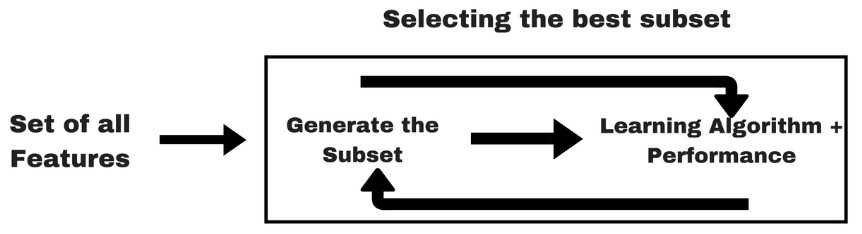

In [4]:
display(Image(parent_folder+"/Classes/gifs/embed.jpg"))

### E3.1. LASSO
* LASSO : Least Absolute Shrinkage and Selection Operator
* Lasso regression performs L1 regularization which adds penalty equivalent to absolute value of the magnitude of coefficients

* cost function
$ J = \frac 1 {m}  \sum\limits_{i=1}^{m}(y^{(i)} - h(x^{(i)}))^2 $
`this will cause overfitting; as well as it can't solve the features with colinearity`
* modified cost function
$ J = \frac{1}{m}( \sum\limits_{i=1}^{m}(y_{(i)}-h(x_{(i)}))^2 + \lambda\sum\limits_{j=1}^{n}|w_j|) $ `all weight are shrunk by a same factor`



In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [ ]:
tmp_clf = tmp.copy()
y = tmp_clf.pop("rul")
tmp_clf.drop(columns=["id", "cycle", "Flag", "Distance_To_Fail"], inplace=True)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

sel_ = SelectFromModel(Lasso(alpha=100))
sel_.fit(scaler.transform(tmp_clf.fillna(0)), y)

In [ ]:
sel_.get_support()

* Math

In [ ]:
class LassoRegression() :      
    def __init__( self, learning_rate, iterations, l1_penality ) :          
        self.learning_rate = learning_rate          
        self.iterations = iterations          
        self.l1_penality = l1_penality          
    # Function for model training
              
    def fit( self, X, Y ) :          
        # no_of_training_examples, no_of_features          
        self.m, self.n = X.shape          
        # weight initialization          
        self.W = np.zeros( self.n )          
        self.b = 0          
        self.X = X          
        self.Y = Y          
        # gradient descent learning                  
        for i in range( self.iterations ) :              
            self.update_weights()              
        return self
      
    # Helper function to update weights in gradient descent      
    def update_weights( self ) :             
        Y_pred = self.predict( self.X )          
        # calculate gradients            
        dW = np.zeros( self.n )          
        for j in range( self.n ) :              
            if self.W[j] > 0 :                  
                dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )                            
                         + self.l1_penality ) / self.m          
            else :                  
                dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )                            
                         - self.l1_penality ) / self.m         
        db = - 2 * np.sum( self.Y - Y_pred ) / self.m           
        # update weights      
        self.W = self.W - self.learning_rate * dW      
        self.b = self.b - self.learning_rate * db          
        return self      
    # Hypothetical function  h( x )       
    def predict( self, X ) :      
        return X.dot( self.W ) + self.b
      

In [ ]:
def main() :      
    # Importing dataset      
    df = pd.read_csv( "salary_data.csv" )  
    X = df.iloc[:, :-1].values  
    Y = df.iloc[:, 1].values      
    # Splitting dataset into train and test set  
    X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 1 / 3, random_state = 0 )      
    # Model training      
    model = LassoRegression( iterations = 1000, learning_rate = 0.01, l1_penality = 500 )  
    model.fit( X_train, Y_train )      
    # Prediction on test set  
    Y_pred = model.predict( X_test )      
    print( "Predicted values ", np.round( Y_pred[:3], 2 ) )       
    print( "Real values      ", Y_test[:3] )      
    print( "Trained W        ", round( model.W[0], 2 ) )      
    print( "Trained b        ", round( model.b, 2 ) )      
    # Visualization on test set       
    plt.scatter( X_test, Y_test, color = 'blue' )      
    plt.plot( X_test, Y_pred, color = 'orange' )      
    plt.title( 'Salary vs Experience' )      
    plt.xlabel( 'Years of Experience' )      
    plt.ylabel( 'Salary' )      
    plt.show()

### E3.2. Ridge
* Ridge is not suitable for feature selection. since it won't reduce coefficient to zero Ridge 不适用于特征选择。 因为它不会将系数减小为零
* cost function
$ J = \frac 1 {m}  \sum\limits_{i=1}^{m}(y^{(i)} - h(x^{(i)}))^2 $
`this will cause overfitting; as well as it can't solve the features with colinearity`
* modified cost function
$ J = \frac{1}{m} \sum\limits_{i=1}^{m}(y_{(i)}-h(x_{(i)}))^2 + \lambda\sum\limits_{i=1}^{n}w^2  $ `all weight are shrunk by a same factor`

* class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), *, fit_intercept=True, normalize='deprecated', scoring=None, cv=None, gcv_mode=None, store_cv_values=False, alpha_per_target=False)

In [ ]:
class RidgeRegression() : 
    def __init__( self, learning_rate, iterations, l2_penality ) :
          
        self.learning_rate = learning_rate        
        self.iterations = iterations        
        self.l2_penality = l2_penality
          
    # Function for model training            
    def fit( self, X, Y ) :
          
        # no_of_training_examples, no_of_features        
        self.m, self.n = X.shape
          
        # weight initialization        
        self.W = np.zeros( self.n )
          
        self.b = 0        
        self.X = X        
        self.Y = Y
          
        # gradient descent learning 
        for i in range( self.iterations ) :            
            self.update_weights()            
        return self
      
    # Helper function to update weights in gradient descent
      
    def update_weights( self ) :           
        Y_pred = self.predict( self.X )
          
        # calculate gradients      
        dW = ( - ( 2 * ( self.X.T ).dot( self.Y - Y_pred ) ) +               
               ( 2 * self.l2_penality * self.W ) ) / self.m     
        db = - 2 * np.sum( self.Y - Y_pred ) / self.m 
          
        # update weights    
        self.W = self.W - self.learning_rate * dW    
        self.b = self.b - self.learning_rate * db        
        return self
      
    # Hypothetical function  h( x ) 
    def predict( self, X ) :    
        return X.dot( self.W ) + self.b
      

In [ ]:
def get_ridge():
    df = pd.read_csv( "salary_data.csv" )
    X = df.iloc[:, :-1].values
    Y = df.iloc[:, 1].values    
  
    # Splitting dataset into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split( X, Y, 
                                            
                                          test_size = 1 / 3, random_state = 0 )
      
    # Model training    
    model = RidgeRegression( iterations = 1000,                             
                            learning_rate = 0.01, l2_penality = 1 )
    model.fit( X_train, Y_train )
      
    # Prediction on test set
    Y_pred = model.predict( X_test )    
    print( "Predicted values ", np.round( Y_pred[:3], 2 ) )     
    print( "Real values      ", Y_test[:3] )    
    print( "Trained W        ", round( model.W[0], 2 ) )    
    print( "Trained b        ", round( model.b, 2 ) )
      
    # Visualization on test set     
    plt.scatter( X_test, Y_test, color = 'blue' )    
    plt.plot( X_test, Y_pred, color = 'orange' )    
    plt.title( 'Salary vs Experience' )    
    plt.xlabel( 'Years of Experience' )    
    plt.ylabel( 'Salary' )    
    plt.show()

### E3.3. Elastic Net 弹性网
* Elastic Net first emerged as a result of critique on lasso, whose variable selection can be too dependent on data and thus unstable. The solution is to combine the penalties of ridge regression and lasso to get the best of both worlds. Elastic Net aims at minimizing the following loss function:

* Elastic Net 最初是由于对 lasso 的批评而出现的，它的变量选择可能过于依赖数据，因此不稳定。 解决方案是将岭回归和套索的惩罚结合起来，以获得两全其美的效果。 弹性网络旨在最小化以下损失函数：

$ J = \frac{1}{m} \sum\limits_{i=1}^{m}(y_{(i)}-h(x_{(i)}))^2 + \lambda((1-\alpha)\sum\limits_{i=1}^{n}w^2 + \alpha\sum\limits_{j=1}^{n}|w_j|) $ `all weight are shrunk by a same factor`


*. Sklearn implementation: <br>
sklearn.linear_model.ElasticNet(alpha=1.0, *, l1_ratio=0.5, fit_intercept=True, normalize='deprecated', precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

# F.  What Is the Best Method? 什么是最好的方法？
* There is no best feature selection method.

* Just like there is no best set of input variables or best machine learning algorithm. At least not universally.

* Instead, you must discover what works best for your specific problem using careful systematic experimentation.

* Try a range of different models fit on different subsets of features chosen via different statistical measures and discover what works best for your specific problem.


* 没有最好的特征选择方法。

* 就像没有最好的输入变量集或最好的机器学习算法一样。 至少不是普遍的。

* 相反，您必须通过仔细的系统实验来发现最适合您的特定问题的方法。

* 尝试一系列不同的模型来适应通过不同统计测量选择的不同特征子集，并发现最适合您的特定问题的模型。
 